In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA # for PCA calculation
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Reshape, UpSampling1D, InputLayer
from tensorflow.keras.optimizers import Adam
df = pd.read_csv('data.csv')
df

FT001  FT003     TT002     TT006   TT006.1     TT007     TT013  \
0     0.039216  0.314  0.716667  0.068966  0.068966  0.714286  0.943925   
1     0.039216  0.314  0.750000  0.068966  0.068966  0.714286  0.943925   
2     0.036765  0.315  0.766667  0.068966  0.068966  0.714286  0.943925   
3     0.036765  0.314  0.800000  0.068966  0.068966  0.714286  0.943925   
4     0.044118  0.314  0.816667  0.068966  0.068966  0.714286  0.953271   
...        ...    ...       ...       ...       ...       ...       ...   
8901  0.036765  0.312  0.716667  0.655172  0.655172  1.000000  0.897196   
8902  0.036765  0.312  0.683333  0.637931  0.637931  0.857143  0.897196   
8903  0.041667  0.314  0.683333  0.620690  0.620690  0.857143  0.897196   
8904  0.036765  0.312  0.650000  0.603448  0.603448  0.857143  0.897196   
8905  0.034314  0.312  0.633333  0.568966  0.568966  0.857143  0.897196   

         FT002     PT007  INTENSIDAD      V001  
0     0.321429  0.692308    0.227699  0.475630  
1     0.107143  0.730769    0.227699  0.482353  
2     0.321429  0.730769    0.227699  0.482353  
3     0.321429  0.730769    0.227699  0.478992  
4     0.107143  0.730769    0.227699  0.489076  
...        ...       ...         ...       ...  
8901  0.285714  0.384615    0.227681  0.584874  
8902  0.500000  0.384615    0.227681  0.583193  
8903  0.321429  0.384615    0.227681  0.581513  
8904  0.428571  0.384615    0.227681  0.583193  
8905  0.785714  0.423077    0.227681  0.578151  

[8906 rows x 11 columns]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import tensorflow as tf


from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

In [3]:
times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.1*len(times))] 
last_40pct = sorted(df.index.values)[-int(0.2*len(times))] 
train = df[(df.index < last_40pct)]  # Training data are 80% of total data
valid = df[(df.index >= last_40pct) & (df.index < last_20pct)]
test = df[(df.index >= last_20pct)]

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(train)/len(df),2),
                                                       round(len(valid)/len(df),2),
                                                       round(len(test)/len(df),2)))

train: 0.8% | validation: 0.1% | test 0.1%


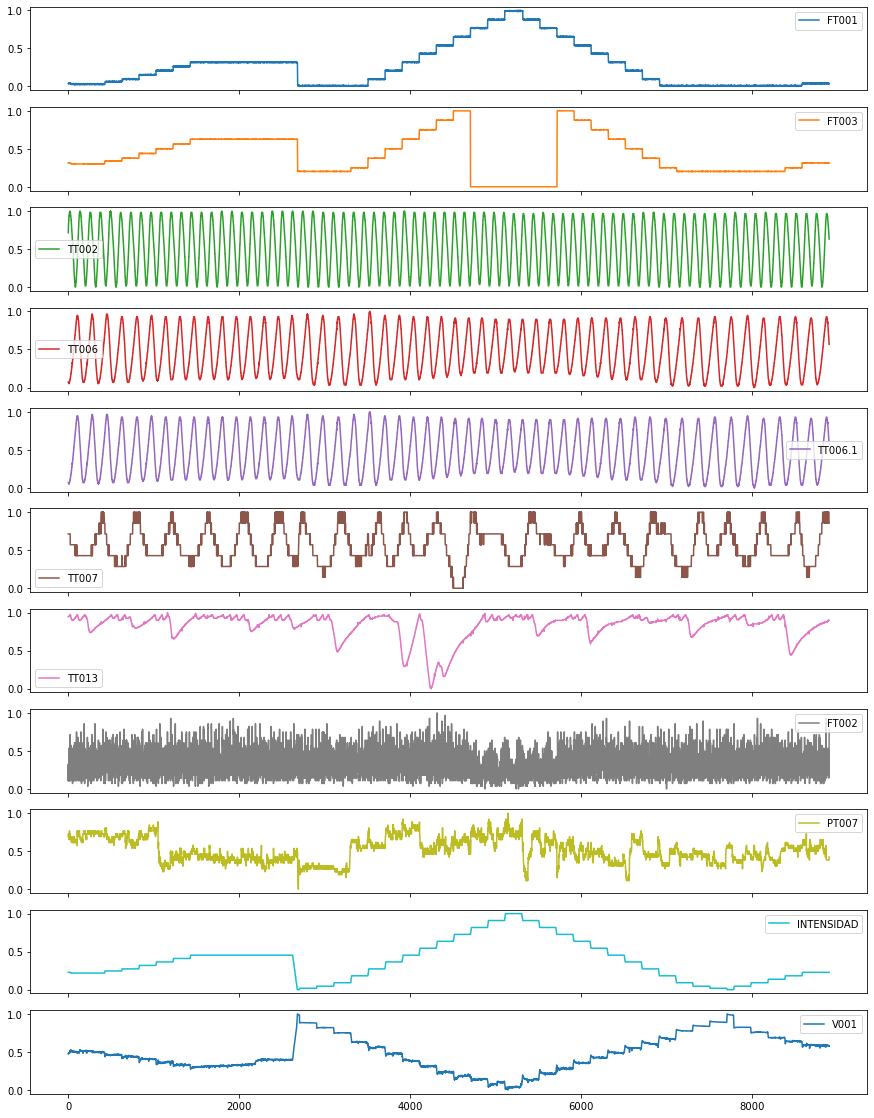

In [4]:
df[df.columns].plot(subplots=True,figsize=(15,20))
plt.show()

In [5]:
window_size = 120

In [6]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
from sklearn.model_selection import train_test_split
#feature_cols = ['FT001', 'FT002', 'FT003', 'FT004','HT001','V001','INTENSIDAD']
feature_cols = df.columns
label_cols = ['V001']

x_train = train
y_train = train['V001']
x_train, y_train = make_dataset(x_train, y_train, window_size)

x_valid = valid
y_valid = valid['V001']
x_valid, y_valid = make_dataset(x_valid, y_valid, window_size)


x_test = test
y_test = test['V001']
x_test, y_test = make_dataset(x_test, y_test,window_size)

In [8]:
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(7005, 120, 11) (7005,)
(771, 120, 11) (771,)
(770, 120, 11) (770,)


In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def MPE(y_true, y_pred): 
    return K.mean((y_true - y_pred) / y_true) * 100
    
def MSLE(y_true, y_pred):
    return K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1)

def RMSLE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM,GRU,Dropout
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = Sequential()
    model.add(GRU(32,input_shape=(x_test.shape[1], x_test.shape[2]),activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(GRU(32, return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss = RMSE, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=[soft_acc, 'mse', 'mae', RMSE, 'mape', MPE, MSLE, RMSLE, R2])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assi

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:

In [11]:
import os
filename = os.path.join('tmp', 'checkpointer.ckpt')
callback = tf.keras.callbacks.ModelCheckpoint(filename, 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    callbacks=[callback, early_stop],
                    validation_data=(x_valid, y_valid))  

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:

 63/219 [=======>......................] - ETA: 57s - loss: 0.1321 - soft_acc: 0.8075 - mse: 0.0244 - mae: 0.1061 - RMSE: 0.1321 - mape: 38.1524 - MPE: -9.1770 - MSLE: 0.0127 - RMSLE: 0.0764 - R2: 0.3370Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


117/219 [===============>..............] - ETA: 37s - loss: 0.1003 - soft_acc: 0.8606 - mse: 0.0150 - mae: 0.0800 - RMSE: 0.1003 - mape: 9621.0439 - MPE: -inf - MSLE: 0.0078 - RMSLE: 0.0573 - R2: 0.5900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


171/219 [======================>.......] - ETA: 17s - loss: 0.0874 - soft_acc: 0.8834 - mse: 0.0114 - mae: 0.0696 - RMSE: 0.0874 - mape: 6587.6748 - MPE: -inf - MSLE: 0.0059 - RMSLE: 0.0496 - R2: 0.6896Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0794 - soft_acc: 0.8945 - mse: 0.0095 - mae: 0.0631 - RMSE: 0.0794 - mape: 5149.0488 - MPE: -inf - MSLE: 0.0049 - RMSLE: 0.0449 - R2: 0.7421Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localh

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 2/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 52/219 [======>.......................] - ETA: 1:05 - loss: 0.0475 - soft_acc: 0.9465 - mse: 0.0023 - mae: 0.0373 - RMSE: 0.0475 - mape: 15.1544 - MPE: -3.2910 - MSLE: 0.0011 - RMSLE: 0.0264 - R2: 0.9345Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 79/219 [=========>....................] - ETA: 54s - loss: 0.0462 - soft_acc: 0.9470 - mse: 0.0022 - mae: 0.0360 - RMSE: 0.0462 - mape: 13.5306 - MPE: -2.2407 - MSLE: 0.0010 - RMSLE: 0.0254 - R2: 0.9382Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 34s - loss: 0.0456 - soft_acc: 0.9469 - mse: 0.0021 - mae: 0.0357 - RMSE: 0.0456 - mape: 12.9072 - MPE: -1.7437 - MSLE: 0.0010 - RMSLE: 0.0250 - R2: 0.9411Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


187/219 [========================>.....] - ETA: 12s - loss: 0.0449 - soft_acc: 0.9487 - mse: 0.0021 - mae: 0.0352 - RMSE: 0.0449 - mape: 12.7349 - MPE: -1.6147 - MSLE: 9.8604e-04 - RMSLE: 0.0247 - R2: 0.9436Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


214/219 [============================>.] - ETA: 1s - loss: 0.0446 - soft_acc: 0.9468 - mse: 0.0021 - mae: 0.0349 - RMSE: 0.0446 - mape: 3669.4688 - MPE: -inf - MSLE: 9.6750e-04 - RMSLE: 0.0245 - R2: 0.9448Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0445 - soft_acc: 0.9468 - mse: 0.0021 - mae: 0.0348 - RMSE: 0.0445 - mape: 3587.4546 - MPE: -inf - MSLE: 9.6411e-04 - RMSLE: 0.0244 - R2: 0.9448Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 63/219 [=======>......................] - ETA: 1:02 - loss: 0.0413 - soft_acc: 0.9464 - mse: 0.0018 - mae: 0.0324 - RMSE: 0.0413 - mape: 5698.1084 - MPE: -inf - MSLE: 8.2544e-04 - RMSLE: 0.0227 - R2: 0.9515Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 90/219 [===========>..................] - ETA: 51s - loss: 0.0398 - soft_acc: 0.9490 - mse: 0.0016 - mae: 0.0309 - RMSE: 0.0398 - mape: 3991.3643 - MPE: -inf - MSLE: 7.6515e-04 - RMSLE: 0.0217 - R2: 0.9547Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


117/219 [===============>..............] - ETA: 40s - loss: 0.0399 - soft_acc: 0.9485 - mse: 0.0016 - mae: 0.0311 - RMSE: 0.0399 - mape: 3072.9241 - MPE: -inf - MSLE: 7.6921e-04 - RMSLE: 0.0218 - R2: 0.9545Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 29s - loss: 0.0390 - soft_acc: 0.9481 - mse: 0.0016 - mae: 0.0303 - RMSE: 0.0390 - mape: 2498.4697 - MPE: -inf - MSLE: 7.3718e-04 - RMSLE: 0.0212 - R2: 0.9566Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


171/219 [======================>.......] - ETA: 18s - loss: 0.0385 - soft_acc: 0.9490 - mse: 0.0015 - mae: 0.0298 - RMSE: 0.0385 - mape: 2105.4358 - MPE: -inf - MSLE: 7.1420e-04 - RMSLE: 0.0209 - R2: 0.9581Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


198/219 [==========================>...] - ETA: 8s - loss: 0.0379 - soft_acc: 0.9509 - mse: 0.0015 - mae: 0.0293 - RMSE: 0.0379 - mape: 1819.4597 - MPE: -inf - MSLE: 6.8981e-04 - RMSLE: 0.0205 - R2: 0.9594Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0378 - soft_acc: 0.9513 - mse: 0.0015 - mae: 0.0293 - RMSE: 0.0378 - mape: 1646.5490 - MPE: -inf - MSLE: 6.8321e-04 - RMSLE: 0.0204 - R2: 0.9599Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

100/219 [============>.................] - ETA: 47s - loss: 0.0349 - soft_acc: 0.9497 - mse: 0.0013 - mae: 0.0266 - RMSE: 0.0349 - mape: 14915.9453 - MPE: -inf - MSLE: 5.7270e-04 - RMSLE: 0.0185 - R2: 0.9656Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


127/219 [================>.............] - ETA: 36s - loss: 0.0343 - soft_acc: 0.9471 - mse: 0.0012 - mae: 0.0262 - RMSE: 0.0343 - mape: 11746.7100 - MPE: -inf - MSLE: 5.5560e-04 - RMSLE: 0.0182 - R2: 0.9669Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


154/219 [====================>.........] - ETA: 25s - loss: 0.0350 - soft_acc: 0.9472 - mse: 0.0013 - mae: 0.0268 - RMSE: 0.0350 - mape: 9689.1455 - MPE: -inf - MSLE: 5.7374e-04 - RMSLE: 0.0186 - R2: 0.9662Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 15s - loss: 0.0347 - soft_acc: 0.9492 - mse: 0.0013 - mae: 0.0265 - RMSE: 0.0347 - mape: 8244.9473 - MPE: -inf - MSLE: 5.6531e-04 - RMSLE: 0.0184 - R2: 0.9664Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


208/219 [===========================>..] - ETA: 4s - loss: 0.0344 - soft_acc: 0.9504 - mse: 0.0012 - mae: 0.0262 - RMSE: 0.0344 - mape: 7175.8154 - MPE: -inf - MSLE: 5.5716e-04 - RMSLE: 0.0182 - R2: 0.9672Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0343 - soft_acc: 0.9510 - mse: 0.0012 - mae: 0.0261 - RMSE: 0.0343 - mape: 6818.7100 - MPE: -inf - MSLE: 5.5211e-04 - RMSLE: 0.0181 - R2: 0.9674Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 5/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 52/219 [======>.......................] - ETA: 1:04 - loss: 0.0341 - soft_acc: 0.9501 - mse: 0.0012 - mae: 0.0258 - RMSE: 0.0341 - mape: 8.7326 - MPE: -0.5123 - MSLE: 5.4637e-04 - RMSLE: 0.0179 - R2: 0.9660Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 79/219 [=========>....................] - ETA: 54s - loss: 0.0326 - soft_acc: 0.9561 - mse: 0.0011 - mae: 0.0248 - RMSE: 0.0326 - mape: 8.8823 - MPE: -0.8635 - MSLE: 5.0952e-04 - RMSLE: 0.0174 - R2: 0.9692Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


106/219 [=============>................] - ETA: 44s - loss: 0.0329 - soft_acc: 0.9525 - mse: 0.0011 - mae: 0.0251 - RMSE: 0.0329 - mape: 22244.4102 - MPE: -inf - MSLE: 5.1538e-04 - RMSLE: 0.0175 - R2: 0.9690Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 33s - loss: 0.0334 - soft_acc: 0.9530 - mse: 0.0012 - mae: 0.0254 - RMSE: 0.0334 - mape: 17730.4551 - MPE: -inf - MSLE: 5.2740e-04 - RMSLE: 0.0177 - R2: 0.9687Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


160/219 [====================>.........] - ETA: 23s - loss: 0.0328 - soft_acc: 0.9529 - mse: 0.0011 - mae: 0.0250 - RMSE: 0.0328 - mape: 14739.8096 - MPE: -inf - MSLE: 5.0865e-04 - RMSLE: 0.0174 - R2: 0.9697Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


187/219 [========================>.....] - ETA: 12s - loss: 0.0323 - soft_acc: 0.9529 - mse: 0.0011 - mae: 0.0246 - RMSE: 0.0323 - mape: 12612.7725 - MPE: -inf - MSLE: 4.9614e-04 - RMSLE: 0.0172 - R2: 0.9705Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


214/219 [============================>.] - ETA: 1s - loss: 0.0321 - soft_acc: 0.9543 - mse: 0.0011 - mae: 0.0245 - RMSE: 0.0321 - mape: 11022.4678 - MPE: -inf - MSLE: 4.9044e-04 - RMSLE: 0.0171 - R2: 0.9709Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0321 - soft_acc: 0.9540 - mse: 0.0011 - mae: 0.0246 - RMSE: 0.0321 - mape: 10775.7275 - MPE: -inf - MSLE: 4.8992e-04 - RMSLE: 0.0171 - R2: 0.9709Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 6/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:13 - loss: 0.0329 - soft_acc: 0.9588 - mse: 0.0011 - mae: 0.0250 - RMSE: 0.0329 - mape: 9.3766 - MPE: -0.0442 - MSLE: 5.1416e-04 - RMSLE: 0.0175 - R2: 0.9711Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 54s - loss: 0.0307 - soft_acc: 0.9635 - mse: 9.7548e-04 - mae: 0.0233 - RMSE: 0.0307 - mape: 14131.5664 - MPE: -inf - MSLE: 4.5441e-04 - RMSLE: 0.0163 - R2: 0.9733Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 35s - loss: 0.0301 - soft_acc: 0.9625 - mse: 9.3645e-04 - mae: 0.0229 - RMSE: 0.0301 - mape: 8438.2344 - MPE: -inf - MSLE: 4.3371e-04 - RMSLE: 0.0160 - R2: 0.9741Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 15s - loss: 0.0301 - soft_acc: 0.9599 - mse: 9.3311e-04 - mae: 0.0230 - RMSE: 0.0301 - mape: 6016.3638 - MPE: -inf - MSLE: 4.3019e-04 - RMSLE: 0.0160 - R2: 0.9746Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0299 - soft_acc: 0.9593 - mse: 9.2148e-04 - mae: 0.0227 - RMSE: 0.0299 - mape: 4975.8457 - MPE: -inf - MSLE: 4.2246e-04 - RMSLE: 0.0158 - R2: 0.9751Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 81/219 [==========>...................] - ETA: 54s - loss: 0.0298 - soft_acc: 0.9568 - mse: 9.1733e-04 - mae: 0.0230 - RMSE: 0.0298 - mape: 7.9543 - MPE: -1.1793 - MSLE: 4.1491e-04 - RMSLE: 0.0159 - R2: 0.9741Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 34s - loss: 0.0302 - soft_acc: 0.9551 - mse: 9.4393e-04 - mae: 0.0232 - RMSE: 0.0302 - mape: 5929.8745 - MPE: -inf - MSLE: 4.2789e-04 - RMSLE: 0.0161 - R2: 0.9736Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


185/219 [========================>.....] - ETA: 13s - loss: 0.0296 - soft_acc: 0.9574 - mse: 9.0674e-04 - mae: 0.0228 - RMSE: 0.0296 - mape: 4265.1553 - MPE: -inf - MSLE: 4.1169e-04 - RMSLE: 0.0158 - R2: 0.9751Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0291 - soft_acc: 0.9583 - mse: 8.7888e-04 - mae: 0.0224 - RMSE: 0.0291 - mape: 3605.7876 - MPE: -inf - MSLE: 4.0124e-04 - RMSLE: 0.0156 - R2: 0.9761Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 85/219 [==========>...................] - ETA: 52s - loss: 0.0263 - soft_acc: 0.9673 - mse: 7.1499e-04 - mae: 0.0201 - RMSE: 0.0263 - mape: 7.8476 - MPE: -1.1792 - MSLE: 3.3579e-04 - RMSLE: 0.0141 - R2: 0.9806Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


137/219 [=================>............] - ETA: 32s - loss: 0.0269 - soft_acc: 0.9630 - mse: 7.5142e-04 - mae: 0.0205 - RMSE: 0.0269 - mape: 7.8670 - MPE: -1.1494 - MSLE: 3.4682e-04 - RMSLE: 0.0143 - R2: 0.9800Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


189/219 [========================>.....] - ETA: 12s - loss: 0.0270 - soft_acc: 0.9616 - mse: 7.5655e-04 - mae: 0.0205 - RMSE: 0.0270 - mape: 14647.8438 - MPE: -inf - MSLE: 3.4715e-04 - RMSLE: 0.0143 - R2: 0.9796Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0275 - soft_acc: 0.9612 - mse: 7.8802e-04 - mae: 0.0209 - RMSE: 0.0275 - mape: 12647.8906 - MPE: -inf - MSLE: 3.6183e-04 - RMSLE: 0.0146 - R2: 0.9791Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 89/219 [===========>..................] - ETA: 51s - loss: 0.0274 - soft_acc: 0.9617 - mse: 7.8673e-04 - mae: 0.0207 - RMSE: 0.0274 - mape: 7.7020 - MPE: -1.0079 - MSLE: 3.5220e-04 - RMSLE: 0.0144 - R2: 0.9799Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


141/219 [==================>...........] - ETA: 31s - loss: 0.0269 - soft_acc: 0.9623 - mse: 7.5229e-04 - mae: 0.0202 - RMSE: 0.0269 - mape: 7.7324 - MPE: -1.1952 - MSLE: 3.3977e-04 - RMSLE: 0.0141 - R2: 0.9805Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


193/219 [=========================>....] - ETA: 10s - loss: 0.0266 - soft_acc: 0.9619 - mse: 7.3239e-04 - mae: 0.0200 - RMSE: 0.0266 - mape: 10994.4062 - MPE: -inf - MSLE: 3.3109e-04 - RMSLE: 0.0139 - R2: 0.9809Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0266 - soft_acc: 0.9613 - mse: 7.3477e-04 - mae: 0.0200 - RMSE: 0.0266 - mape: 9694.1240 - MPE: -inf - MSLE: 3.3208e-04 - RMSLE: 0.0139 - R2: 0.9805Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhos

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Execu

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 93/219 [===========>..................] - ETA: 50s - loss: 0.0259 - soft_acc: 0.9654 - mse: 6.9370e-04 - mae: 0.0195 - RMSE: 0.0259 - mape: 7.2860 - MPE: -1.0744 - MSLE: 3.1479e-04 - RMSLE: 0.0136 - R2: 0.9813Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


145/219 [==================>...........] - ETA: 29s - loss: 0.0257 - soft_acc: 0.9625 - mse: 6.8246e-04 - mae: 0.0192 - RMSE: 0.0257 - mape: 10694.5928 - MPE: -inf - MSLE: 3.0977e-04 - RMSLE: 0.0134 - R2: 0.9814Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


197/219 [=========================>....] - ETA: 8s - loss: 0.0261 - soft_acc: 0.9600 - mse: 7.0405e-04 - mae: 0.0196 - RMSE: 0.0261 - mape: 7873.5693 - MPE: -inf - MSLE: 3.1863e-04 - RMSLE: 0.0136 - R2: 0.9808Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0261 - soft_acc: 0.9618 - mse: 7.0710e-04 - mae: 0.0197 - RMSE: 0.0261 - mape: 7086.4424 - MPE: -inf - MSLE: 3.2131e-04 - RMSLE: 0.0137 - R2: 0.9810Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 72/219 [========>.....................] - ETA: 58s - loss: 0.0256 - soft_acc: 0.9614 - mse: 6.8273e-04 - mae: 0.0194 - RMSE: 0.0256 - mape: 7.5586 - MPE: -1.4690 - MSLE: 3.1357e-04 - RMSLE: 0.0135 - R2: 0.9819Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


124/219 [===============>..............] - ETA: 37s - loss: 0.0255 - soft_acc: 0.9637 - mse: 6.7660e-04 - mae: 0.0193 - RMSE: 0.0255 - mape: 7.3324 - MPE: -1.1338 - MSLE: 3.1140e-04 - RMSLE: 0.0135 - R2: 0.9820Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


176/219 [=======================>......] - ETA: 17s - loss: 0.0251 - soft_acc: 0.9654 - mse: 6.5429e-04 - mae: 0.0190 - RMSE: 0.0251 - mape: 7.1026 - MPE: -1.0759 - MSLE: 3.0066e-04 - RMSLE: 0.0132 - R2: 0.9827Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0249 - soft_acc: 0.9656 - mse: 6.4367e-04 - mae: 0.0188 - RMSE: 0.0249 - mape: 8033.4639 - MPE: -inf - MSLE: 2.9536e-04 - RMSLE: 0.0131 - R2: 0.9830Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 90s 410ms/step - loss: 0.0249 - soft_acc: 0.9656 - mse: 6.4367e-04 - mae: 0.0188 - RMSE: 0.0249 - mape: 8033.4639 - MPE: -inf - MSLE: 2.9536e-04 - RMSLE: 0.0131 - R2: 0.9830 - val_loss: 0.0188 - val_soft_acc: 1.0000 - val_mse: 5.8801e-04 - val_mae: 0.0172 - val_RMSE: 0.0186 - val_mape: 1.9469 - val_MPE: 0.6769 - val_MSLE: 1.6335e-04 - val_RMSLE: 0.0091 - val_R2: -5123.5293

Epoch 00011: val_loss did not improve from 0.01681
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 12/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:18 - loss: 0.0231 - soft_acc: 0.9588 - mse: 5.5687e-04 - mae: 0.0170 - RMSE: 0.0231 - mape: 6.7422 - MPE: -1.4057 - MSLE: 2.5809e-04 - RMSLE: 0.0119 - R2: 0.9858Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 57s - loss: 0.0260 - soft_acc: 0.9602 - mse: 7.0455e-04 - mae: 0.0194 - RMSE: 0.0260 - mape: 7.4189 - MPE: -1.3752 - MSLE: 3.2422e-04 - RMSLE: 0.0136 - R2: 0.9816Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 36s - loss: 0.0252 - soft_acc: 0.9634 - mse: 6.6227e-04 - mae: 0.0188 - RMSE: 0.0252 - mape: 7.4047 - MPE: -1.1714 - MSLE: 3.0402e-04 - RMSLE: 0.0131 - R2: 0.9829Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 15s - loss: 0.0251 - soft_acc: 0.9641 - mse: 6.5580e-04 - mae: 0.0187 - RMSE: 0.0251 - mape: 7.4323 - MPE: -1.2406 - MSLE: 3.0250e-04 - RMSLE: 0.0131 - R2: 0.9826Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0247 - soft_acc: 0.9633 - mse: 6.3869e-04 - mae: 0.0184 - RMSE: 0.0247 - mape: 7528.0889 - MPE: -inf - MSLE: 2.9353e-04 - RMSLE: 0.0128 - R2: 0.9832Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 81/219 [==========>...................] - ETA: 55s - loss: 0.0232 - soft_acc: 0.9688 - mse: 5.5762e-04 - mae: 0.0174 - RMSE: 0.0232 - mape: 6217.1572 - MPE: -inf - MSLE: 2.5402e-04 - RMSLE: 0.0121 - R2: 0.9854Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 34s - loss: 0.0230 - soft_acc: 0.9692 - mse: 5.5000e-04 - mae: 0.0173 - RMSE: 0.0230 - mape: 3789.3142 - MPE: -inf - MSLE: 2.5662e-04 - RMSLE: 0.0121 - R2: 0.9856Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


185/219 [========================>.....] - ETA: 13s - loss: 0.0228 - soft_acc: 0.9691 - mse: 5.4076e-04 - mae: 0.0171 - RMSE: 0.0228 - mape: 2726.1934 - MPE: -inf - MSLE: 2.5395e-04 - RMSLE: 0.0120 - R2: 0.9857Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0231 - soft_acc: 0.9686 - mse: 5.5863e-04 - mae: 0.0174 - RMSE: 0.0231 - mape: 2305.1306 - MPE: -inf - MSLE: 2.6203e-04 - RMSLE: 0.0122 - R2: 0.9852Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 14/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:14 - loss: 0.0249 - soft_acc: 0.9737 - mse: 6.3833e-04 - mae: 0.0186 - RMSE: 0.0249 - mape: 7.7974 - MPE: -0.8815 - MSLE: 2.9882e-04 - RMSLE: 0.0131 - R2: 0.9837Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 55s - loss: 0.0235 - soft_acc: 0.9683 - mse: 5.7187e-04 - mae: 0.0176 - RMSE: 0.0235 - mape: 23529.1152 - MPE: -inf - MSLE: 2.6840e-04 - RMSLE: 0.0124 - R2: 0.9850Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 35s - loss: 0.0237 - soft_acc: 0.9651 - mse: 5.8527e-04 - mae: 0.0178 - RMSE: 0.0237 - mape: 14047.4980 - MPE: -inf - MSLE: 2.7553e-04 - RMSLE: 0.0125 - R2: 0.9847Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 14s - loss: 0.0233 - soft_acc: 0.9629 - mse: 5.6571e-04 - mae: 0.0175 - RMSE: 0.0233 - mape: 10013.7422 - MPE: -inf - MSLE: 2.6661e-04 - RMSLE: 0.0123 - R2: 0.9850Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0231 - soft_acc: 0.9632 - mse: 5.5623e-04 - mae: 0.0174 - RMSE: 0.0231 - mape: 8280.8740 - MPE: -inf - MSLE: 2.6100e-04 - RMSLE: 0.0122 - R2: 0.9852Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 81/219 [==========>...................] - ETA: 55s - loss: 0.0225 - soft_acc: 0.9657 - mse: 5.2713e-04 - mae: 0.0169 - RMSE: 0.0225 - mape: 226.6496 - MPE: -inf - MSLE: 2.4276e-04 - RMSLE: 0.0118 - R2: 0.9860Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 34s - loss: 0.0224 - soft_acc: 0.9699 - mse: 5.1940e-04 - mae: 0.0166 - RMSE: 0.0224 - mape: 140.6317 - MPE: -inf - MSLE: 2.3859e-04 - RMSLE: 0.0116 - R2: 0.9864Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


185/219 [========================>.....] - ETA: 13s - loss: 0.0223 - soft_acc: 0.9686 - mse: 5.1501e-04 - mae: 0.0166 - RMSE: 0.0223 - mape: 102.9288 - MPE: -inf - MSLE: 2.3821e-04 - RMSLE: 0.0116 - R2: 0.9864Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0223 - soft_acc: 0.9684 - mse: 5.1541e-04 - mae: 0.0165 - RMSE: 0.0223 - mape: 88.0168 - MPE: -inf - MSLE: 2.3986e-04 - RMSLE: 0.0115 - R2: 0.9865Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
E

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 85/219 [==========>...................] - ETA: 53s - loss: 0.0219 - soft_acc: 0.9739 - mse: 5.0493e-04 - mae: 0.0161 - RMSE: 0.0219 - mape: 7.1451 - MPE: -1.3727 - MSLE: 2.4059e-04 - RMSLE: 0.0114 - R2: 0.9867Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


137/219 [=================>............] - ETA: 33s - loss: 0.0219 - soft_acc: 0.9708 - mse: 5.0455e-04 - mae: 0.0162 - RMSE: 0.0219 - mape: 6.8324 - MPE: -0.9466 - MSLE: 2.3794e-04 - RMSLE: 0.0114 - R2: 0.9868Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


189/219 [========================>.....] - ETA: 12s - loss: 0.0218 - soft_acc: 0.9711 - mse: 4.9656e-04 - mae: 0.0160 - RMSE: 0.0218 - mape: 8618.2578 - MPE: -inf - MSLE: 2.3410e-04 - RMSLE: 0.0113 - R2: 0.9871Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0219 - soft_acc: 0.9704 - mse: 5.0250e-04 - mae: 0.0162 - RMSE: 0.0219 - mape: 7441.9854 - MPE: -inf - MSLE: 2.3730e-04 - RMSLE: 0.0114 - R2: 0.9869Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 17/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:13 - loss: 0.0228 - soft_acc: 0.9700 - mse: 5.4037e-04 - mae: 0.0175 - RMSE: 0.0228 - mape: 6.8996 - MPE: -0.1725 - MSLE: 2.5901e-04 - RMSLE: 0.0124 - R2: 0.9849Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 56s - loss: 0.0209 - soft_acc: 0.9692 - mse: 4.5214e-04 - mae: 0.0159 - RMSE: 0.0209 - mape: 6.4171 - MPE: -0.4788 - MSLE: 2.1541e-04 - RMSLE: 0.0112 - R2: 0.9876Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 37s - loss: 0.0219 - soft_acc: 0.9688 - mse: 4.9604e-04 - mae: 0.0163 - RMSE: 0.0219 - mape: 6.6486 - MPE: -0.6943 - MSLE: 2.3198e-04 - RMSLE: 0.0115 - R2: 0.9868Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 16s - loss: 0.0219 - soft_acc: 0.9703 - mse: 4.9800e-04 - mae: 0.0163 - RMSE: 0.0219 - mape: 2092.4099 - MPE: -inf - MSLE: 2.3340e-04 - RMSLE: 0.0114 - R2: 0.9869Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0217 - soft_acc: 0.9697 - mse: 4.8996e-04 - mae: 0.0162 - RMSE: 0.0217 - mape: 1731.0331 - MPE: -inf - MSLE: 2.2962e-04 - RMSLE: 0.0113 - R2: 0.9870Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 81/219 [==========>...................] - ETA: 58s - loss: 0.0229 - soft_acc: 0.9684 - mse: 5.4619e-04 - mae: 0.0171 - RMSE: 0.0229 - mape: 17490.9863 - MPE: -inf - MSLE: 2.6476e-04 - RMSLE: 0.0120 - R2: 0.9857Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 37s - loss: 0.0221 - soft_acc: 0.9685 - mse: 5.1164e-04 - mae: 0.0165 - RMSE: 0.0221 - mape: 10655.2090 - MPE: -inf - MSLE: 2.4741e-04 - RMSLE: 0.0116 - R2: 0.9865Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


185/219 [========================>.....] - ETA: 14s - loss: 0.0219 - soft_acc: 0.9698 - mse: 5.0353e-04 - mae: 0.0162 - RMSE: 0.0219 - mape: 7662.1182 - MPE: -inf - MSLE: 2.4170e-04 - RMSLE: 0.0114 - R2: 0.9867Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0215 - soft_acc: 0.9703 - mse: 4.8469e-04 - mae: 0.0160 - RMSE: 0.0215 - mape: 6476.2690 - MPE: -inf - MSLE: 2.3338e-04 - RMSLE: 0.0112 - R2: 0.9872Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 85/219 [==========>...................] - ETA: 57s - loss: 0.0201 - soft_acc: 0.9688 - mse: 4.1982e-04 - mae: 0.0148 - RMSE: 0.0201 - mape: 15096.0029 - MPE: -inf - MSLE: 1.9440e-04 - RMSLE: 0.0103 - R2: 0.9887Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


137/219 [=================>............] - ETA: 34s - loss: 0.0205 - soft_acc: 0.9706 - mse: 4.3298e-04 - mae: 0.0151 - RMSE: 0.0205 - mape: 9368.7100 - MPE: -inf - MSLE: 2.0508e-04 - RMSLE: 0.0106 - R2: 0.9883Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


189/219 [========================>.....] - ETA: 12s - loss: 0.0207 - soft_acc: 0.9696 - mse: 4.4660e-04 - mae: 0.0151 - RMSE: 0.0207 - mape: 6793.0020 - MPE: -inf - MSLE: 2.1099e-04 - RMSLE: 0.0106 - R2: 0.9882Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0207 - soft_acc: 0.9687 - mse: 4.4851e-04 - mae: 0.0152 - RMSE: 0.0207 - mape: 5865.8525 - MPE: -inf - MSLE: 2.1345e-04 - RMSLE: 0.0107 - R2: 0.9881Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 89/219 [===========>..................] - ETA: 51s - loss: 0.0231 - soft_acc: 0.9691 - mse: 5.6140e-04 - mae: 0.0176 - RMSE: 0.0231 - mape: 7.0979 - MPE: -1.0987 - MSLE: 2.6252e-04 - RMSLE: 0.0123 - R2: 0.9857Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


141/219 [==================>...........] - ETA: 30s - loss: 0.0221 - soft_acc: 0.9703 - mse: 5.1786e-04 - mae: 0.0168 - RMSE: 0.0221 - mape: 2612.0747 - MPE: -inf - MSLE: 2.4707e-04 - RMSLE: 0.0118 - R2: 0.9867Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


193/219 [=========================>....] - ETA: 10s - loss: 0.0217 - soft_acc: 0.9702 - mse: 4.9667e-04 - mae: 0.0164 - RMSE: 0.0217 - mape: 1910.0089 - MPE: -inf - MSLE: 2.3643e-04 - RMSLE: 0.0115 - R2: 0.9870Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0217 - soft_acc: 0.9699 - mse: 4.9679e-04 - mae: 0.0164 - RMSE: 0.0217 - mape: 1684.8337 - MPE: -inf - MSLE: 2.3760e-04 - RMSLE: 0.0116 - R2: 0.9867Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/d

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 68/219 [========>.....................] - ETA: 1:00 - loss: 0.0208 - soft_acc: 0.9710 - mse: 4.4838e-04 - mae: 0.0154 - RMSE: 0.0208 - mape: 2835.6775 - MPE: -inf - MSLE: 2.1182e-04 - RMSLE: 0.0108 - R2: 0.9882Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


120/219 [===============>..............] - ETA: 40s - loss: 0.0208 - soft_acc: 0.9711 - mse: 4.5104e-04 - mae: 0.0155 - RMSE: 0.0208 - mape: 1609.9019 - MPE: -inf - MSLE: 2.1652e-04 - RMSLE: 0.0109 - R2: 0.9880Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


172/219 [======================>.......] - ETA: 19s - loss: 0.0202 - soft_acc: 0.9709 - mse: 4.2683e-04 - mae: 0.0150 - RMSE: 0.0202 - mape: 1125.0613 - MPE: -inf - MSLE: 2.0633e-04 - RMSLE: 0.0106 - R2: 0.9886Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0199 - soft_acc: 0.9697 - mse: 4.1339e-04 - mae: 0.0147 - RMSE: 0.0199 - mape: 885.2274 - MPE: -inf - MSLE: 1.9951e-04 - RMSLE: 0.0104 - R2: 0.9891Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 99/219 [============>.................] - ETA: 48s - loss: 0.0209 - soft_acc: 0.9706 - mse: 4.5275e-04 - mae: 0.0153 - RMSE: 0.0209 - mape: 6.9197 - MPE: -0.6344 - MSLE: 2.1874e-04 - RMSLE: 0.0108 - R2: 0.9880Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


151/219 [===================>..........] - ETA: 27s - loss: 0.0204 - soft_acc: 0.9692 - mse: 4.3568e-04 - mae: 0.0151 - RMSE: 0.0204 - mape: 6.8982 - MPE: -0.7994 - MSLE: 2.1342e-04 - RMSLE: 0.0106 - R2: 0.9885Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


203/219 [==========================>...] - ETA: 6s - loss: 0.0204 - soft_acc: 0.9695 - mse: 4.3434e-04 - mae: 0.0150 - RMSE: 0.0204 - mape: 10938.2344 - MPE: -inf - MSLE: 2.1290e-04 - RMSLE: 0.0106 - R2: 0.9886Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0203 - soft_acc: 0.9697 - mse: 4.3255e-04 - mae: 0.0150 - RMSE: 0.0203 - mape: 10143.8457 - MPE: -inf - MSLE: 2.1170e-04 - RMSLE: 0.0106 - R2: 0.9886Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local


Epoch 00022: val_loss did not improve from 0.01496
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


 78/219 [=========>....................] - ETA: 54s - loss: 0.0207 - soft_acc: 0.9683 - mse: 4.6001e-04 - mae: 0.0152 - RMSE: 0.0207 - mape: 6.7092 - MPE: -0.8211 - MSLE: 2.1795e-04 - RMSLE: 0.0107 - R2: 0.9882Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


130/219 [================>.............] - ETA: 34s - loss: 0.0204 - soft_acc: 0.9726 - mse: 4.4214e-04 - mae: 0.0151 - RMSE: 0.0204 - mape: 7648.8184 - MPE: -inf - MSLE: 2.0969e-04 - RMSLE: 0.0106 - R2: 0.9887Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


182/219 [=======================>......] - ETA: 14s - loss: 0.0199 - soft_acc: 0.9717 - mse: 4.2176e-04 - mae: 0.0148 - RMSE: 0.0199 - mape: 5465.2036 - MPE: -inf - MSLE: 2.0113e-04 - RMSLE: 0.0104 - R2: 0.9890Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0198 - soft_acc: 0.9717 - mse: 4.1556e-04 - mae: 0.0147 - RMSE: 0.0198 - mape: 4544.9526 - MPE: -inf - MSLE: 2.0021e-04 - RMSLE: 0.0104 - R2: 0.9891Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 82/219 [==========>...................] - ETA: 54s - loss: 0.0196 - soft_acc: 0.9726 - mse: 3.9836e-04 - mae: 0.0146 - RMSE: 0.0196 - mape: 6.1264 - MPE: -0.8761 - MSLE: 1.9470e-04 - RMSLE: 0.0103 - R2: 0.9896Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


134/219 [=================>............] - ETA: 33s - loss: 0.0203 - soft_acc: 0.9713 - mse: 4.2855e-04 - mae: 0.0152 - RMSE: 0.0203 - mape: 6.5843 - MPE: -0.9639 - MSLE: 2.1157e-04 - RMSLE: 0.0108 - R2: 0.9888Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


186/219 [========================>.....] - ETA: 13s - loss: 0.0201 - soft_acc: 0.9731 - mse: 4.2193e-04 - mae: 0.0149 - RMSE: 0.0201 - mape: 1354.0985 - MPE: -inf - MSLE: 2.1004e-04 - RMSLE: 0.0106 - R2: 0.9890Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0201 - soft_acc: 0.9729 - mse: 4.2201e-04 - mae: 0.0149 - RMSE: 0.0201 - mape: 1151.6959 - MPE: -inf - MSLE: 2.0984e-04 - RMSLE: 0.0105 - R2: 0.9889Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 86/219 [==========>...................] - ETA: 52s - loss: 0.0194 - soft_acc: 0.9764 - mse: 3.9502e-04 - mae: 0.0141 - RMSE: 0.0194 - mape: 6.2669 - MPE: -1.2403 - MSLE: 1.9264e-04 - RMSLE: 0.0099 - R2: 0.9896Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


138/219 [=================>............] - ETA: 32s - loss: 0.0193 - soft_acc: 0.9744 - mse: 3.8898e-04 - mae: 0.0140 - RMSE: 0.0193 - mape: 4289.4575 - MPE: -inf - MSLE: 1.9242e-04 - RMSLE: 0.0099 - R2: 0.9897Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


190/219 [=========================>....] - ETA: 11s - loss: 0.0193 - soft_acc: 0.9734 - mse: 3.9057e-04 - mae: 0.0140 - RMSE: 0.0193 - mape: 3117.1733 - MPE: -inf - MSLE: 1.9174e-04 - RMSLE: 0.0099 - R2: 0.9897Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0193 - soft_acc: 0.9730 - mse: 3.9174e-04 - mae: 0.0141 - RMSE: 0.0193 - mape: 2706.2810 - MPE: -inf - MSLE: 1.9152e-04 - RMSLE: 0.0100 - R2: 0.9897Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 90/219 [===========>..................] - ETA: 53s - loss: 0.0201 - soft_acc: 0.9729 - mse: 4.2424e-04 - mae: 0.0149 - RMSE: 0.0201 - mape: 16801.0898 - MPE: -inf - MSLE: 2.0637e-04 - RMSLE: 0.0105 - R2: 0.9890Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


142/219 [==================>...........] - ETA: 32s - loss: 0.0200 - soft_acc: 0.9732 - mse: 4.1996e-04 - mae: 0.0150 - RMSE: 0.0200 - mape: 10650.8701 - MPE: -inf - MSLE: 2.0528e-04 - RMSLE: 0.0106 - R2: 0.9889Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


194/219 [=========================>....] - ETA: 10s - loss: 0.0199 - soft_acc: 0.9741 - mse: 4.1521e-04 - mae: 0.0148 - RMSE: 0.0199 - mape: 7797.6450 - MPE: -inf - MSLE: 2.0343e-04 - RMSLE: 0.0105 - R2: 0.9890Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0200 - soft_acc: 0.9740 - mse: 4.1614e-04 - mae: 0.0149 - RMSE: 0.0200 - mape: 6911.2686 - MPE: -inf - MSLE: 2.0408e-04 - RMSLE: 0.0105 - R2: 0.9891Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 69/219 [========>.....................] - ETA: 1:03 - loss: 0.0191 - soft_acc: 0.9746 - mse: 3.7736e-04 - mae: 0.0140 - RMSE: 0.0191 - mape: 5.8216 - MPE: -0.8477 - MSLE: 1.7988e-04 - RMSLE: 0.0099 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


121/219 [===============>..............] - ETA: 41s - loss: 0.0195 - soft_acc: 0.9770 - mse: 3.9536e-04 - mae: 0.0143 - RMSE: 0.0195 - mape: 6.3996 - MPE: -1.0497 - MSLE: 1.9578e-04 - RMSLE: 0.0101 - R2: 0.9897Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


173/219 [======================>.......] - ETA: 19s - loss: 0.0199 - soft_acc: 0.9734 - mse: 4.0831e-04 - mae: 0.0146 - RMSE: 0.0199 - mape: 12788.4873 - MPE: -inf - MSLE: 2.0545e-04 - RMSLE: 0.0104 - R2: 0.9893Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0199 - soft_acc: 0.9727 - mse: 4.1096e-04 - mae: 0.0147 - RMSE: 0.0199 - mape: 10108.1221 - MPE: -inf - MSLE: 2.0689e-04 - RMSLE: 0.0104 - R2: 0.9892Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in d

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 28/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/219 [=====>........................] - ETA: 1:11 - loss: 0.0189 - soft_acc: 0.9694 - mse: 3.7130e-04 - mae: 0.0137 - RMSE: 0.0189 - mape: 6085.8862 - MPE: -inf - MSLE: 1.8886e-04 - RMSLE: 0.0097 - R2: 0.9904Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


102/219 [============>.................] - ETA: 49s - loss: 0.0192 - soft_acc: 0.9688 - mse: 3.8617e-04 - mae: 0.0140 - RMSE: 0.0192 - mape: 2986.3560 - MPE: -inf - MSLE: 1.9056e-04 - RMSLE: 0.0099 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


154/219 [====================>.........] - ETA: 27s - loss: 0.0191 - soft_acc: 0.9706 - mse: 3.8261e-04 - mae: 0.0140 - RMSE: 0.0191 - mape: 1980.2959 - MPE: -inf - MSLE: 1.9278e-04 - RMSLE: 0.0100 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


206/219 [===========================>..] - ETA: 5s - loss: 0.0190 - soft_acc: 0.9709 - mse: 3.7754e-04 - mae: 0.0139 - RMSE: 0.0190 - mape: 1482.1298 - MPE: -inf - MSLE: 1.8969e-04 - RMSLE: 0.0099 - R2: 0.9901Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0189 - soft_acc: 0.9717 - mse: 3.7414e-04 - mae: 0.0138 - RMSE: 0.0189 - mape: 1395.0736 - MPE: -inf - MSLE: 1.8758e-04 - RMSLE: 0.0098 - R2: 0.9901Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 58s - loss: 0.0187 - soft_acc: 0.9758 - mse: 3.7074e-04 - mae: 0.0136 - RMSE: 0.0187 - mape: 6.9247 - MPE: -1.3778 - MSLE: 1.9513e-04 - RMSLE: 0.0098 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 36s - loss: 0.0189 - soft_acc: 0.9756 - mse: 3.7681e-04 - mae: 0.0138 - RMSE: 0.0189 - mape: 3958.9998 - MPE: -inf - MSLE: 1.9182e-04 - RMSLE: 0.0098 - R2: 0.9902Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 14s - loss: 0.0191 - soft_acc: 0.9730 - mse: 3.8747e-04 - mae: 0.0140 - RMSE: 0.0191 - mape: 2841.9971 - MPE: -inf - MSLE: 1.9491e-04 - RMSLE: 0.0100 - R2: 0.9899Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0191 - soft_acc: 0.9727 - mse: 3.8495e-04 - mae: 0.0140 - RMSE: 0.0191 - mape: 2389.7620 - MPE: -inf - MSLE: 1.9248e-04 - RMSLE: 0.0099 - R2: 0.9899Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 57s - loss: 0.0195 - soft_acc: 0.9688 - mse: 3.9837e-04 - mae: 0.0146 - RMSE: 0.0195 - mape: 6.0908 - MPE: -0.8049 - MSLE: 1.9338e-04 - RMSLE: 0.0103 - R2: 0.9891Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 35s - loss: 0.0190 - soft_acc: 0.9706 - mse: 3.7548e-04 - mae: 0.0142 - RMSE: 0.0190 - mape: 8664.2354 - MPE: -inf - MSLE: 1.8650e-04 - RMSLE: 0.0100 - R2: 0.9897Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 13s - loss: 0.0190 - soft_acc: 0.9714 - mse: 3.7614e-04 - mae: 0.0141 - RMSE: 0.0190 - mape: 6269.5771 - MPE: -inf - MSLE: 1.8891e-04 - RMSLE: 0.0100 - R2: 0.9899Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0190 - soft_acc: 0.9712 - mse: 3.7569e-04 - mae: 0.0141 - RMSE: 0.0189 - mape: 5385.5293 - MPE: -inf - MSLE: 1.9067e-04 - RMSLE: 0.0100 - R2: 0.9901Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 55s - loss: 0.0188 - soft_acc: 0.9698 - mse: 3.6352e-04 - mae: 0.0135 - RMSE: 0.0188 - mape: 5.8661 - MPE: -0.7860 - MSLE: 1.7724e-04 - RMSLE: 0.0095 - R2: 0.9901Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 33s - loss: 0.0190 - soft_acc: 0.9717 - mse: 3.7191e-04 - mae: 0.0137 - RMSE: 0.0190 - mape: 7664.2480 - MPE: -inf - MSLE: 1.8626e-04 - RMSLE: 0.0098 - R2: 0.9901Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 11s - loss: 0.0189 - soft_acc: 0.9735 - mse: 3.6906e-04 - mae: 0.0136 - RMSE: 0.0189 - mape: 5590.1367 - MPE: -inf - MSLE: 1.8441e-04 - RMSLE: 0.0097 - R2: 0.9902Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0190 - soft_acc: 0.9723 - mse: 3.7519e-04 - mae: 0.0137 - RMSE: 0.0190 - mape: 4903.8032 - MPE: -inf - MSLE: 1.8683e-04 - RMSLE: 0.0097 - R2: 0.9901Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 54s - loss: 0.0195 - soft_acc: 0.9728 - mse: 3.9895e-04 - mae: 0.0146 - RMSE: 0.0195 - mape: 6.7560 - MPE: -1.3585 - MSLE: 1.9722e-04 - RMSLE: 0.0104 - R2: 0.9898Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 32s - loss: 0.0192 - soft_acc: 0.9727 - mse: 3.8625e-04 - mae: 0.0143 - RMSE: 0.0192 - mape: 12329.6201 - MPE: -inf - MSLE: 1.9339e-04 - RMSLE: 0.0102 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 9s - loss: 0.0191 - soft_acc: 0.9724 - mse: 3.8012e-04 - mae: 0.0141 - RMSE: 0.0191 - mape: 9060.3408 - MPE: -inf - MSLE: 1.9115e-04 - RMSLE: 0.0101 - R2: 0.9900 Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0191 - soft_acc: 0.9726 - mse: 3.7922e-04 - mae: 0.0141 - RMSE: 0.0191 - mape: 8112.8887 - MPE: -inf - MSLE: 1.8942e-04 - RMSLE: 0.0100 - R2: 0.9900Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 1:03 - loss: 0.0190 - soft_acc: 0.9723 - mse: 3.7781e-04 - mae: 0.0137 - RMSE: 0.0190 - mape: 6.7666 - MPE: -1.1955 - MSLE: 1.9517e-04 - RMSLE: 0.0098 - R2: 0.9900Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 40s - loss: 0.0187 - soft_acc: 0.9728 - mse: 3.6646e-04 - mae: 0.0135 - RMSE: 0.0187 - mape: 6.8235 - MPE: -1.2601 - MSLE: 1.9092e-04 - RMSLE: 0.0096 - R2: 0.9903Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 18s - loss: 0.0188 - soft_acc: 0.9741 - mse: 3.6995e-04 - mae: 0.0136 - RMSE: 0.0188 - mape: 9168.7061 - MPE: -inf - MSLE: 1.9087e-04 - RMSLE: 0.0097 - R2: 0.9903Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0185 - soft_acc: 0.9742 - mse: 3.6037e-04 - mae: 0.0134 - RMSE: 0.0185 - mape: 7330.8452 - MPE: -inf - MSLE: 1.8454e-04 - RMSLE: 0.0095 - R2: 0.9905Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 94s 430ms/step - loss: 0.0185 - soft_acc: 0.9742 - mse: 3.6037e-04 - mae: 0.0134 - RMSE: 0.0185 - mape: 7330.8452 - MPE: -inf - MSLE: 1.8454e-04 - RMSLE: 0.0095 - R2: 0.9905 - val_loss: 0.0202 - val_soft_acc: 1.0000 - val_mse: 5.8319e-04 - val_mae: 0.0186 - val_RMSE: 0.0195 - val_mape: 2.1061 - val_MPE: 1.6479 - val_MSLE: 1.6182e-04 - val_RMSLE: 0.0099 - val_R2: -11404.4697

Epoch 00033: val_loss did not improve from 0.01383
Executing op Cast in device /job:localhost/replica:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 34/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:24 - loss: 0.0192 - soft_acc: 0.9727 - mse: 3.8140e-04 - mae: 0.0140 - RMSE: 0.0192 - mape: 7.3525 - MPE: -1.1494 - MSLE: 1.9829e-04 - RMSLE: 0.0100 - R2: 0.9902Executing op __inference_train_function_7763

 76/219 [=========>....................] - ETA: 1:03 - loss: 0.0192 - soft_acc: 0.9679 - mse: 3.8412e-04 - mae: 0.0141 - RMSE: 0.0192 - mape: 6.4262 - MPE: -1.1692 - MSLE: 1.9217e-04 - RMSLE: 0.0100 - R2: 0.9895Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 39s - loss: 0.0186 - soft_acc: 0.9688 - mse: 3.6042e-04 - mae: 0.0137 - RMSE: 0.0186 - mape: 6.6143 - MPE: -1.1791 - MSLE: 1.8413e-04 - RMSLE: 0.0098 - R2: 0.9904Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 16s - loss: 0.0185 - soft_acc: 0.9726 - mse: 3.5934e-04 - mae: 0.0136 - RMSE: 0.0185 - mape: 8686.8311 - MPE: -inf - MSLE: 1.8199e-04 - RMSLE: 0.0097 - R2: 0.9905Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0189 - soft_acc: 0.9717 - mse: 3.7495e-04 - mae: 0.0140 - RMSE: 0.0189 - mape: 7144.1279 - MPE: -inf - MSLE: 1.8952e-04 - RMSLE: 0.0100 - R2: 0.9901Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 1:02 - loss: 0.0200 - soft_acc: 0.9734 - mse: 4.2235e-04 - mae: 0.0147 - RMSE: 0.0200 - mape: 10296.8916 - MPE: -inf - MSLE: 2.1873e-04 - RMSLE: 0.0106 - R2: 0.9888Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 38s - loss: 0.0199 - soft_acc: 0.9735 - mse: 4.1693e-04 - mae: 0.0149 - RMSE: 0.0199 - mape: 6242.9785 - MPE: -inf - MSLE: 2.1078e-04 - RMSLE: 0.0106 - R2: 0.9890Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 15s - loss: 0.0195 - soft_acc: 0.9732 - mse: 3.9907e-04 - mae: 0.0144 - RMSE: 0.0195 - mape: 4480.4517 - MPE: -inf - MSLE: 2.0141e-04 - RMSLE: 0.0102 - R2: 0.9895Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0194 - soft_acc: 0.9733 - mse: 3.9307e-04 - mae: 0.0143 - RMSE: 0.0194 - mape: 3767.0127 - MPE: -inf - MSLE: 1.9865e-04 - RMSLE: 0.0102 - R2: 0.9896Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 57s - loss: 0.0184 - soft_acc: 0.9769 - mse: 3.5421e-04 - mae: 0.0133 - RMSE: 0.0184 - mape: 6.0470 - MPE: -0.4774 - MSLE: 1.7508e-04 - RMSLE: 0.0094 - R2: 0.9906Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 36s - loss: 0.0186 - soft_acc: 0.9770 - mse: 3.5888e-04 - mae: 0.0136 - RMSE: 0.0186 - mape: 6.4024 - MPE: -0.7312 - MSLE: 1.8146e-04 - RMSLE: 0.0097 - R2: 0.9905Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 13s - loss: 0.0187 - soft_acc: 0.9744 - mse: 3.6205e-04 - mae: 0.0136 - RMSE: 0.0187 - mape: 8940.7715 - MPE: -inf - MSLE: 1.8344e-04 - RMSLE: 0.0097 - R2: 0.9903Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0186 - soft_acc: 0.9737 - mse: 3.5841e-04 - mae: 0.0136 - RMSE: 0.0186 - mape: 7679.2847 - MPE: -inf - MSLE: 1.8154e-04 - RMSLE: 0.0097 - R2: 0.9905Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 55s - loss: 0.0188 - soft_acc: 0.9751 - mse: 3.7268e-04 - mae: 0.0141 - RMSE: 0.0188 - mape: 10448.2803 - MPE: -inf - MSLE: 1.9268e-04 - RMSLE: 0.0101 - R2: 0.9903Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 33s - loss: 0.0184 - soft_acc: 0.9741 - mse: 3.5481e-04 - mae: 0.0136 - RMSE: 0.0184 - mape: 6569.6953 - MPE: -inf - MSLE: 1.8263e-04 - RMSLE: 0.0097 - R2: 0.9907Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 11s - loss: 0.0184 - soft_acc: 0.9728 - mse: 3.5634e-04 - mae: 0.0137 - RMSE: 0.0184 - mape: 4792.3574 - MPE: -inf - MSLE: 1.8531e-04 - RMSLE: 0.0098 - R2: 0.9906Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0184 - soft_acc: 0.9730 - mse: 3.5647e-04 - mae: 0.0137 - RMSE: 0.0184 - mape: 4204.0288 - MPE: -inf - MSLE: 1.8541e-04 - RMSLE: 0.0098 - R2: 0.9906Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 53s - loss: 0.0184 - soft_acc: 0.9755 - mse: 3.5354e-04 - mae: 0.0132 - RMSE: 0.0184 - mape: 11797.8516 - MPE: -inf - MSLE: 1.7718e-04 - RMSLE: 0.0093 - R2: 0.9906Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 31s - loss: 0.0186 - soft_acc: 0.9740 - mse: 3.6143e-04 - mae: 0.0135 - RMSE: 0.0186 - mape: 7540.0088 - MPE: -inf - MSLE: 1.8740e-04 - RMSLE: 0.0097 - R2: 0.9904Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 9s - loss: 0.0187 - soft_acc: 0.9750 - mse: 3.6282e-04 - mae: 0.0136 - RMSE: 0.0187 - mape: 5541.4111 - MPE: -inf - MSLE: 1.8728e-04 - RMSLE: 0.0097 - R2: 0.9904 Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0184 - soft_acc: 0.9750 - mse: 3.5442e-04 - mae: 0.0134 - RMSE: 0.0184 - mape: 4962.1392 - MPE: -inf - MSLE: 1.8267e-04 - RMSLE: 0.0096 - R2: 0.9907Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 1:03 - loss: 0.0189 - soft_acc: 0.9767 - mse: 3.8009e-04 - mae: 0.0140 - RMSE: 0.0189 - mape: 6.6968 - MPE: -1.3654 - MSLE: 1.9253e-04 - RMSLE: 0.0100 - R2: 0.9902Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 40s - loss: 0.0186 - soft_acc: 0.9754 - mse: 3.6432e-04 - mae: 0.0138 - RMSE: 0.0186 - mape: 6.9753 - MPE: -1.4101 - MSLE: 1.8789e-04 - RMSLE: 0.0098 - R2: 0.9907Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 18s - loss: 0.0182 - soft_acc: 0.9750 - mse: 3.4851e-04 - mae: 0.0134 - RMSE: 0.0182 - mape: 13168.4346 - MPE: -inf - MSLE: 1.7995e-04 - RMSLE: 0.0096 - R2: 0.9909Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0182 - soft_acc: 0.9747 - mse: 3.5051e-04 - mae: 0.0135 - RMSE: 0.0182 - mape: 10528.3691 - MPE: -inf - MSLE: 1.8113e-04 - RMSLE: 0.0096 - R2: 0.9909Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 92s 422ms/step - loss: 0.0182 - soft_acc: 0.9747 - mse: 3.5051e-04 - mae: 0.0135 - RMSE: 0.0182 - mape: 10528.3691 - MPE: -inf - MSLE: 1.8113e-04 - RMSLE: 0.0096 - R2: 0.9909 - val_loss: 0.0342 - val_soft_acc: 1.0000 - val_mse: 0.0013 - val_mae: 0.0333 - val_RMSE: 0.0336 - val_mape: 3.8061 - val_MPE: 3.5859 - val_MSLE: 3.8089e-04 - val_RMSLE: 0.0179 - val_R2: -54735.7031

Epoch 00039: val_loss did not improve from 0.01383
Executing op Cast in device /job:localhost/replica:0/t

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 40/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:20 - loss: 0.0175 - soft_acc: 0.9831 - mse: 3.1877e-04 - mae: 0.0126 - RMSE: 0.0175 - mape: 5.5514 - MPE: -0.9284 - MSLE: 1.6462e-04 - RMSLE: 0.0090 - R2: 0.9914Executing op __inference_train_function_7763

 76/219 [=========>....................] - ETA: 57s - loss: 0.0178 - soft_acc: 0.9749 - mse: 3.2981e-04 - mae: 0.0130 - RMSE: 0.0178 - mape: 6.1337 - MPE: -1.0886 - MSLE: 1.7065e-04 - RMSLE: 0.0093 - R2: 0.9912Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 36s - loss: 0.0185 - soft_acc: 0.9753 - mse: 3.5965e-04 - mae: 0.0135 - RMSE: 0.0185 - mape: 2117.1301 - MPE: -inf - MSLE: 1.8411e-04 - RMSLE: 0.0097 - R2: 0.9906Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 15s - loss: 0.0186 - soft_acc: 0.9743 - mse: 3.6157e-04 - mae: 0.0137 - RMSE: 0.0186 - mape: 1507.3401 - MPE: -inf - MSLE: 1.8281e-04 - RMSLE: 0.0098 - R2: 0.9905Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0185 - soft_acc: 0.9755 - mse: 3.5709e-04 - mae: 0.0136 - RMSE: 0.0185 - mape: 1240.5352 - MPE: -inf - MSLE: 1.8014e-04 - RMSLE: 0.0097 - R2: 0.9906Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 55s - loss: 0.0176 - soft_acc: 0.9785 - mse: 3.2494e-04 - mae: 0.0126 - RMSE: 0.0176 - mape: 6.2539 - MPE: -0.9754 - MSLE: 1.6933e-04 - RMSLE: 0.0091 - R2: 0.9910Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 34s - loss: 0.0179 - soft_acc: 0.9770 - mse: 3.3160e-04 - mae: 0.0128 - RMSE: 0.0179 - mape: 6.1613 - MPE: -1.1497 - MSLE: 1.7238e-04 - RMSLE: 0.0092 - R2: 0.9911Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 14s - loss: 0.0179 - soft_acc: 0.9752 - mse: 3.3252e-04 - mae: 0.0130 - RMSE: 0.0179 - mape: 4181.3599 - MPE: -inf - MSLE: 1.7246e-04 - RMSLE: 0.0093 - R2: 0.9909Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0179 - soft_acc: 0.9757 - mse: 3.3272e-04 - mae: 0.0130 - RMSE: 0.0179 - mape: 3515.5081 - MPE: -inf - MSLE: 1.7073e-04 - RMSLE: 0.0093 - R2: 0.9910Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 53s - loss: 0.0179 - soft_acc: 0.9714 - mse: 3.3740e-04 - mae: 0.0132 - RMSE: 0.0179 - mape: 6.5030 - MPE: -1.0429 - MSLE: 1.7292e-04 - RMSLE: 0.0094 - R2: 0.9912Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 33s - loss: 0.0179 - soft_acc: 0.9733 - mse: 3.3713e-04 - mae: 0.0133 - RMSE: 0.0179 - mape: 7573.9307 - MPE: -inf - MSLE: 1.7512e-04 - RMSLE: 0.0095 - R2: 0.9911Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 12s - loss: 0.0181 - soft_acc: 0.9734 - mse: 3.4239e-04 - mae: 0.0134 - RMSE: 0.0181 - mape: 5480.5142 - MPE: -inf - MSLE: 1.7593e-04 - RMSLE: 0.0096 - R2: 0.9910Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0183 - soft_acc: 0.9737 - mse: 3.5021e-04 - mae: 0.0135 - RMSE: 0.0183 - mape: 4707.7554 - MPE: -inf - MSLE: 1.7980e-04 - RMSLE: 0.0096 - R2: 0.9907Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 52s - loss: 0.0174 - soft_acc: 0.9737 - mse: 3.1509e-04 - mae: 0.0128 - RMSE: 0.0174 - mape: 6.3253 - MPE: -1.0986 - MSLE: 1.6584e-04 - RMSLE: 0.0092 - R2: 0.9917Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 31s - loss: 0.0175 - soft_acc: 0.9741 - mse: 3.1981e-04 - mae: 0.0128 - RMSE: 0.0175 - mape: 5.9534 - MPE: -0.7474 - MSLE: 1.6324e-04 - RMSLE: 0.0091 - R2: 0.9915Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 10s - loss: 0.0175 - soft_acc: 0.9751 - mse: 3.1862e-04 - mae: 0.0127 - RMSE: 0.0175 - mape: 5.8405 - MPE: -0.7348 - MSLE: 1.6182e-04 - RMSLE: 0.0091 - R2: 0.9916Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0176 - soft_acc: 0.9762 - mse: 3.2389e-04 - mae: 0.0128 - RMSE: 0.0176 - mape: 2297.3865 - MPE: -inf - MSLE: 1.6409e-04 - RMSLE: 0.0091 - R2: 0.9915Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 50s - loss: 0.0178 - soft_acc: 0.9738 - mse: 3.2975e-04 - mae: 0.0127 - RMSE: 0.0178 - mape: 6.6668 - MPE: -1.3153 - MSLE: 1.7474e-04 - RMSLE: 0.0091 - R2: 0.9913Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 29s - loss: 0.0175 - soft_acc: 0.9759 - mse: 3.2080e-04 - mae: 0.0126 - RMSE: 0.0175 - mape: 6.2997 - MPE: -1.1673 - MSLE: 1.6773e-04 - RMSLE: 0.0090 - R2: 0.9914Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 9s - loss: 0.0175 - soft_acc: 0.9754 - mse: 3.1782e-04 - mae: 0.0126 - RMSE: 0.0175 - mape: 11736.9736 - MPE: -inf - MSLE: 1.6451e-04 - RMSLE: 0.0090 - R2: 0.9915Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0175 - soft_acc: 0.9754 - mse: 3.1787e-04 - mae: 0.0126 - RMSE: 0.0175 - mape: 10509.6064 - MPE: -inf - MSLE: 1.6545e-04 - RMSLE: 0.0090 - R2: 0.9915Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 58s - loss: 0.0180 - soft_acc: 0.9771 - mse: 3.3700e-04 - mae: 0.0129 - RMSE: 0.0180 - mape: 6.2693 - MPE: -1.2180 - MSLE: 1.7487e-04 - RMSLE: 0.0092 - R2: 0.9909Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 38s - loss: 0.0173 - soft_acc: 0.9779 - mse: 3.1476e-04 - mae: 0.0125 - RMSE: 0.0173 - mape: 6.0656 - MPE: -1.2193 - MSLE: 1.6272e-04 - RMSLE: 0.0090 - R2: 0.9916Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 17s - loss: 0.0174 - soft_acc: 0.9779 - mse: 3.1658e-04 - mae: 0.0127 - RMSE: 0.0174 - mape: 9423.8311 - MPE: -inf - MSLE: 1.6443e-04 - RMSLE: 0.0091 - R2: 0.9917Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0175 - soft_acc: 0.9779 - mse: 3.2106e-04 - mae: 0.0127 - RMSE: 0.0175 - mape: 7534.9849 - MPE: -inf - MSLE: 1.6814e-04 - RMSLE: 0.0091 - R2: 0.9915Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 89s 409ms/step - loss: 0.0175 - soft_acc: 0.9779 - mse: 3.2106e-04 - mae: 0.0127 - RMSE: 0.0175 - mape: 7534.9849 - MPE: -inf - MSLE: 1.6814e-04 - RMSLE: 0.0091 - R2: 0.9915 - val_loss: 0.0475 - val_soft_acc: 1.0000 - val_mse: 0.0025 - val_mae: 0.0468 - val_RMSE: 0.0466 - val_mape: 5.3612 - val_MPE: 5.2235 - val_MSLE: 7.2521e-04 - val_RMSLE: 0.0253 - val_R2: -106622.7109

Epoch 00045: val_loss did not improve from 0.01383
Executing op Cast in device /job:localhost/replica:0/t

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 46/100
Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:20 - loss: 0.0187 - soft_acc: 0.9701 - mse: 3.6423e-04 - mae: 0.0142 - RMSE: 0.0187 - mape: 16911.0527 - MPE: -inf - MSLE: 1.9560e-04 - RMSLE: 0.0102 - R2: 0.9906Executing op __inference_train_function_776

 76/219 [=========>....................] - ETA: 58s - loss: 0.0185 - soft_acc: 0.9708 - mse: 3.5802e-04 - mae: 0.0139 - RMSE: 0.0185 - mape: 5344.9619 - MPE: -inf - MSLE: 1.8548e-04 - RMSLE: 0.0100 - R2: 0.9905Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 36s - loss: 0.0183 - soft_acc: 0.9724 - mse: 3.4767e-04 - mae: 0.0135 - RMSE: 0.0183 - mape: 3176.3660 - MPE: -inf - MSLE: 1.8062e-04 - RMSLE: 0.0097 - R2: 0.9909Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 15s - loss: 0.0180 - soft_acc: 0.9748 - mse: 3.3917e-04 - mae: 0.0132 - RMSE: 0.0180 - mape: 2260.2913 - MPE: -inf - MSLE: 1.7381e-04 - RMSLE: 0.0095 - R2: 0.9911Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0176 - soft_acc: 0.9753 - mse: 3.2558e-04 - mae: 0.0129 - RMSE: 0.0176 - mape: 1859.4750 - MPE: -inf - MSLE: 1.6717e-04 - RMSLE: 0.0093 - R2: 0.9914Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 57s - loss: 0.0178 - soft_acc: 0.9703 - mse: 3.3162e-04 - mae: 0.0132 - RMSE: 0.0178 - mape: 5.8199 - MPE: -0.5051 - MSLE: 1.6599e-04 - RMSLE: 0.0094 - R2: 0.9914Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 35s - loss: 0.0181 - soft_acc: 0.9737 - mse: 3.4534e-04 - mae: 0.0134 - RMSE: 0.0181 - mape: 6.1655 - MPE: -0.7979 - MSLE: 1.7169e-04 - RMSLE: 0.0095 - R2: 0.9910Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 14s - loss: 0.0181 - soft_acc: 0.9749 - mse: 3.4495e-04 - mae: 0.0133 - RMSE: 0.0181 - mape: 3854.0728 - MPE: inf - MSLE: 1.7252e-04 - RMSLE: 0.0095 - R2: 0.9909Executing op __inference_train_function_7763 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0183 - soft_acc: 0.9750 - mse: 3.5275e-04 - mae: 0.0135 - RMSE: 0.0183 - mape: 3240.6094 - MPE: inf - MSLE: 1.7836e-04 - RMSLE: 0.0096 - R2: 0.9907Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

In [12]:
#Calculate predication for training, validation and test data
train_pred = model.predict(x_train)
valid_pred = model.predict(x_valid)
test_pred = model.predict(x_test)

#Print evaluation metrics for all datasets
train_evaluate = model.evaluate(x_train, y_train, verbose=0)
valid_evaluate = model.evaluate(x_valid, y_valid, verbose=0)
test_evaluate = model.evaluate(x_test, y_test, verbose=0)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:

Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:

Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_216393 in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ComputeBatchSize in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_11400 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

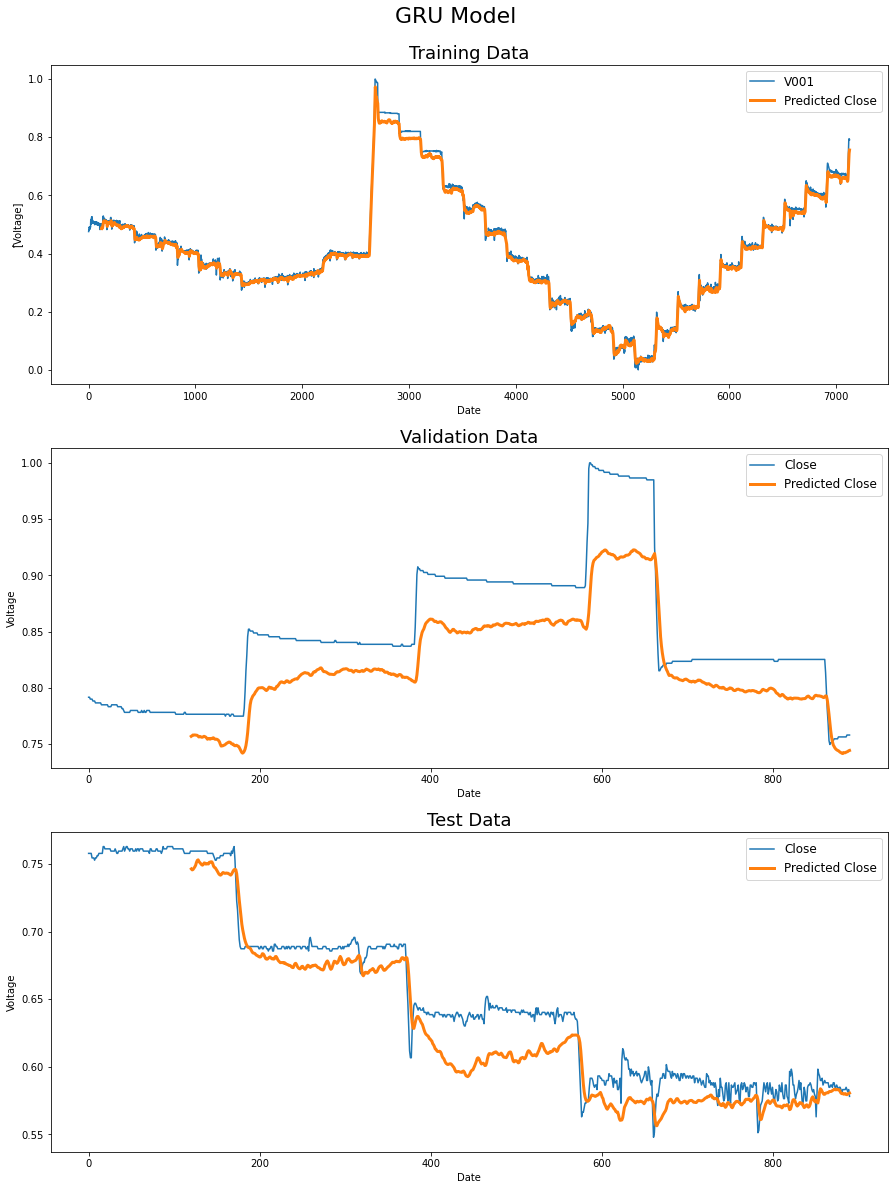

In [13]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("GRU Model", fontsize=22)
st.set_y(0.92)
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train.values[:, -1], label='V001')
ax11.plot(np.arange(window_size, train_pred.shape[0]+window_size), train_pred, linewidth=3, label='Predicted Close')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('ٌ[Voltage]')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(valid.values[:, -1], label='Close')
ax21.plot(np.arange(window_size, valid_pred.shape[0]+window_size), valid_pred, linewidth=3, label='Predicted Close')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test.values[:, -1], label='Close')
ax31.plot(np.arange(window_size, test_pred.shape[0]+window_size), test_pred, linewidth=3, label='Predicted Close')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Voltage')
ax31.legend(loc="best", fontsize=12)

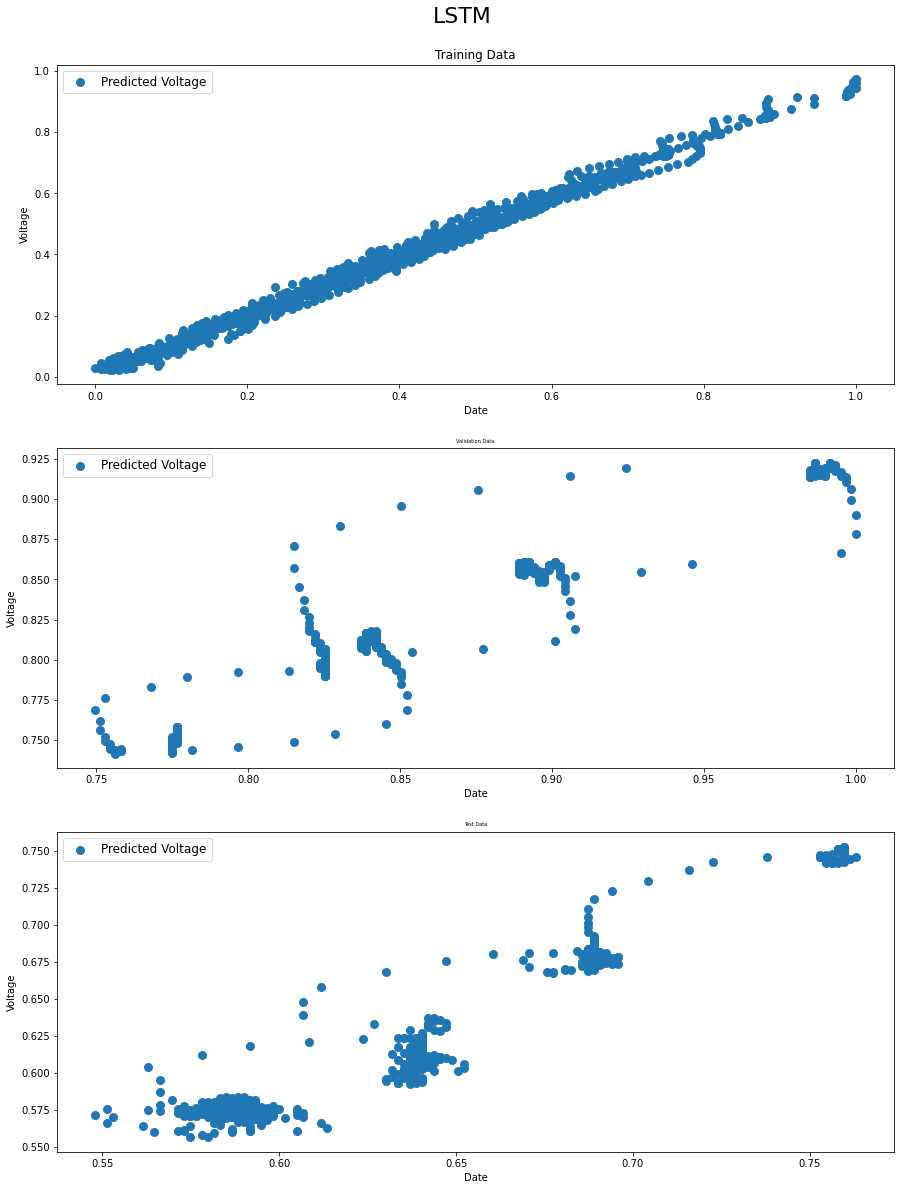

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
'''Display results'''
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("LSTM", fontsize=22)
st.set_y(0.92)
#Plot training data results
ax11 = fig.add_subplot(311)
plt.scatter(np.asarray(y_train), train_pred, linewidth=3, label='Predicted Voltage')
ax11.set_title("Training Data", fontsize=12)
ax11.set_xlabel('Date')
ax11.set_ylabel('Voltage')
ax11.legend(loc="best", fontsize=12)


#Plot validation data results
ax21 = fig.add_subplot(312)
plt.scatter(np.asarray(y_valid), valid_pred, linewidth=3, label='Predicted Voltage')
ax21.set_title("Validation Data", fontsize=5)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax21 = fig.add_subplot(313)
plt.scatter(np.asarray(y_test), test_pred, linewidth=3, label='Predicted Voltage')
ax21.set_title("Test Data", fontsize=5)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

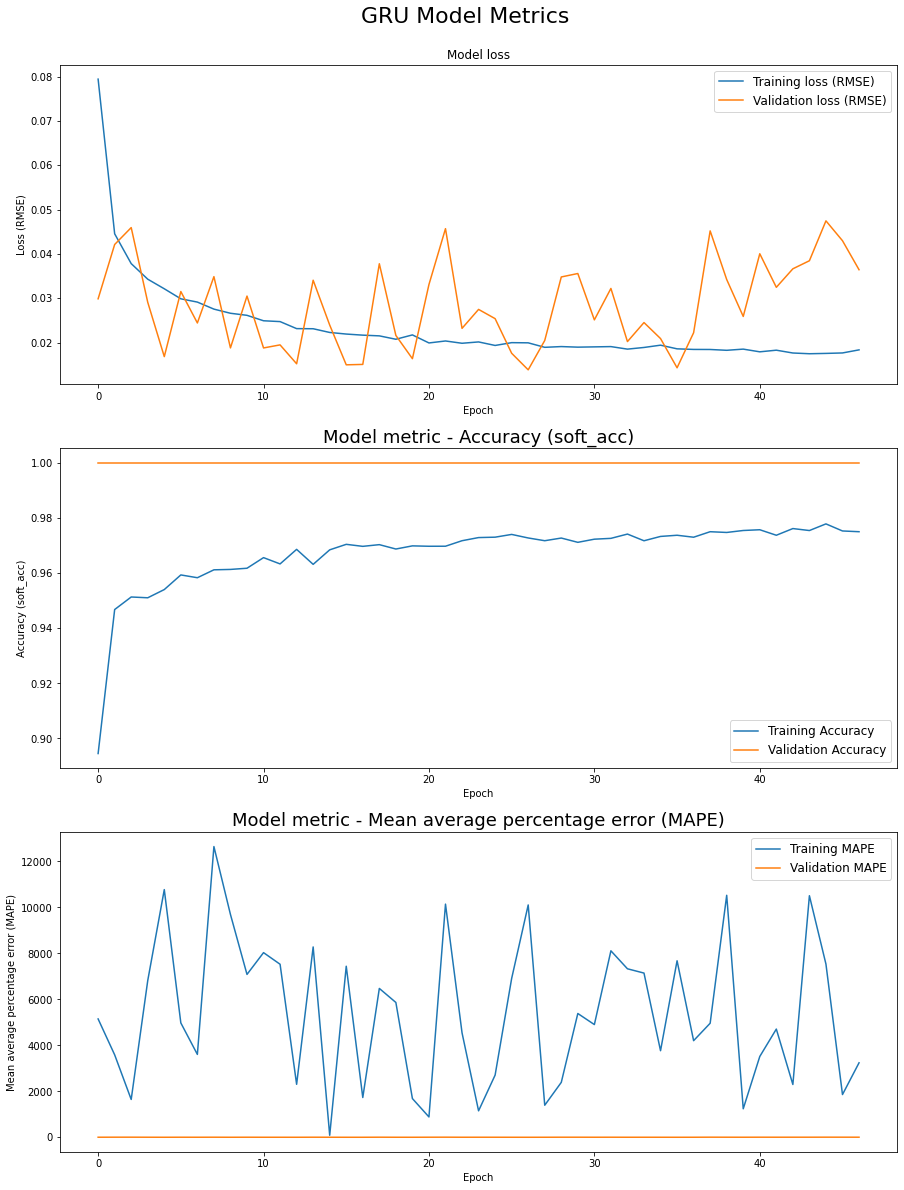

In [15]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("GRU Model Metrics", fontsize=22)
st.set_y(0.92)
#Plot Model Loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (RMSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (RMSE)')
ax1.set_title("Model loss", fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (RMSE)')
ax1.legend(loc="best", fontsize=12)
#Plot Model Acurracy
ax2 = fig.add_subplot(312)
ax2.plot(history.history['soft_acc'], label='Training Accuracy')
ax2.plot(history.history['val_soft_acc'], label='Validation Accuracy')
ax2.set_title("Model metric - Accuracy (soft_acc)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (soft_acc)')
ax2.legend(loc="best", fontsize=12)
#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [16]:
import numpy as np


print('R2_Score')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[9], valid_evaluate[9], test_evaluate[9]))

print('Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[2], valid_evaluate[2], test_evaluate[2]))

print('Mean Absolute Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[3], valid_evaluate[3], test_evaluate[3]))

print('Root Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[4], valid_evaluate[4], test_evaluate[4]))

print('Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[7], valid_evaluate[7], test_evaluate[7]))

print('Root Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[8], valid_evaluate[8], test_evaluate[8]))

print('Mean Absolute Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[5], valid_evaluate[5], test_evaluate[5]))

print('Mean Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[6], valid_evaluate[6], test_evaluate[6]))

R2_Score
----------------------------------------
train error: -3690.182861328125 |
valid error: -54791.6484375 |
test error : -60.38788986206055

Mean Squared Error
----------------------------------------
train error: 0.00017886297428049147 |
valid error: 0.0015685402322560549 |
test error : 0.0004046137910336256

Mean Absolute Error
----------------------------------------
train error: 0.009822526946663857 |
valid error: 0.035541657358407974 |
test error : 0.017077244818210602

Root Mean Squared Error
----------------------------------------
train error: 0.01122312992811203 |
valid error: 0.03561512380838394 |
test error : 0.01742394082248211

Mean Squared Logarithmic Error
----------------------------------------
train error: 7.777455175528303e-05 |
valid error: 0.0004452451248653233 |
test error : 0.0001540254452265799

Root Mean Squared Logarithmic Error
----------------------------------------
train error: 0.006705708801746368 |
valid error: 0.019132759422063828 |
test error : 0

In [17]:
model.save('GRU.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
